In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/transactions.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


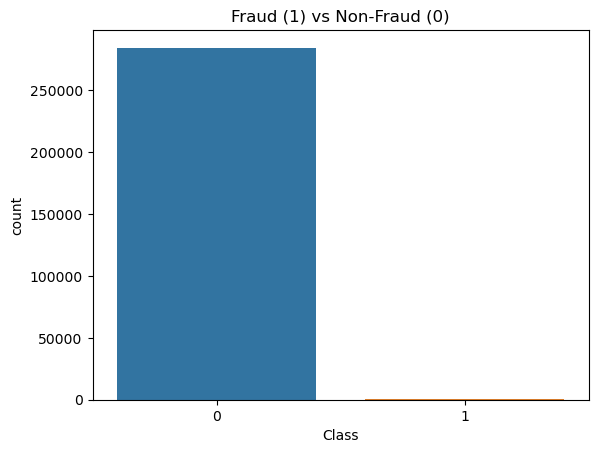

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [3]:
sns.countplot(data=df, x='Class')
plt.title('Fraud (1) vs Non-Fraud (0)')
plt.show()

print(df['Class'].value_counts(normalize=True))

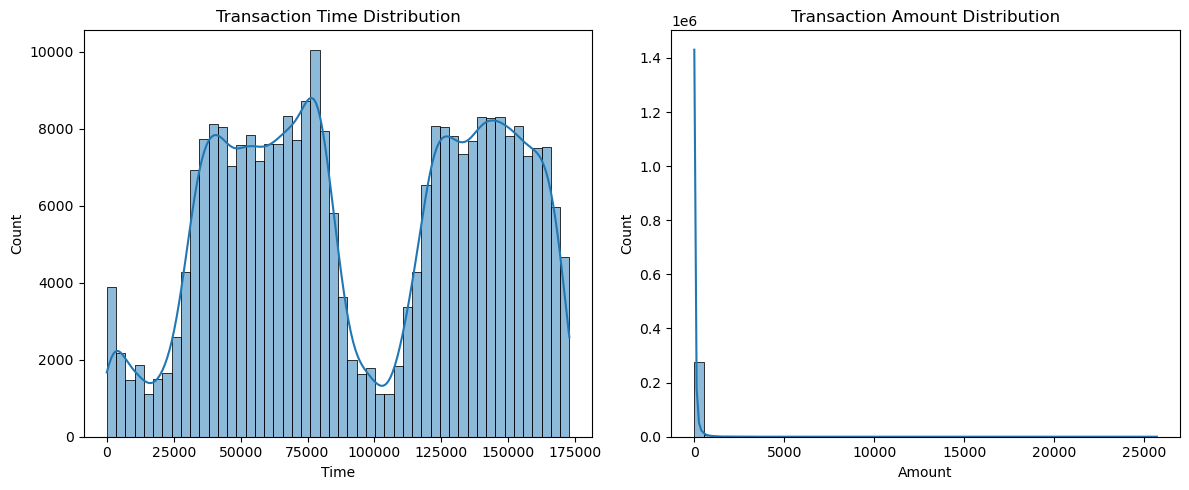

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Time'], bins=50, ax=ax[0], kde=True)
sns.histplot(df['Amount'], bins=50, ax=ax[1], kde=True)
ax[0].set_title('Transaction Time Distribution')
ax[1].set_title('Transaction Amount Distribution')
plt.tight_layout()
plt.show()

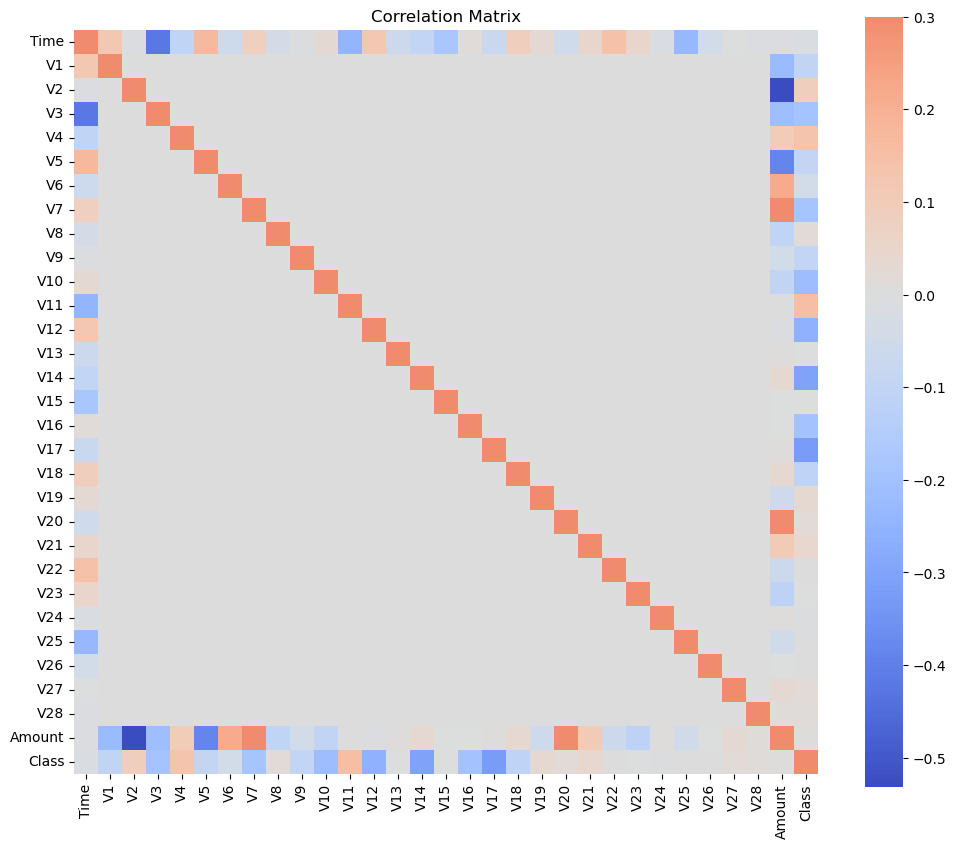

In [5]:
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmax=0.3, center=0, square=True)
plt.title("Correlation Matrix")
plt.show()

In [6]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [7]:
df.to_csv('../data/cleaned_transactions.csv', index=False)
print("Data preprocessing complete. Cleaned data saved to 'cleaned_transactions.csv'.")

Data preprocessing complete. Cleaned data saved to 'cleaned_transactions.csv'.
